In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pyfrechet.metric_spaces import MetricData
import pyfrechet.metric_spaces.wasserstein_1d as W1d
from scipy.optimize import minimize
from scipy import stats

INFO: Using numpy backend


In [3]:
filenames = ['./data/frbny-sce-public-microdata-latest 2.csv',
             './data/FRBNY-SCE-Public-Microdata-Complete-13-16.csv',
             './data/FRBNY-SCE-Public-Microdata-Complete-17-19.csv']
df = pd.concat([pd.read_csv(filename, sep=';', skiprows=1, low_memory=False) for filename in filenames])

print("Average # responses per month: ", df.groupby('date')['userid'].count().mean())

# truncate the distributions to [-12, 12] by removing bin1 and bin10
sdf = df[['date', 'Q9_bin2', 'Q9_bin3', 'Q9_bin4', 'Q9_bin5', 'Q9_bin6',
       'Q9_bin7', 'Q9_bin8', 'Q9_bin9']].copy()

sdf_all = df[['date', 'Q9_bin1', 'Q9_bin2', 'Q9_bin3', 'Q9_bin4', 'Q9_bin5', 'Q9_bin6',
       'Q9_bin7', 'Q9_bin8', 'Q9_bin9', 'Q9_bin10']]

sdf_all = sdf_all[~sdf_all.isna().any(axis=1)]
sums = sdf_all[[f'Q9_bin{i}' for i in range(1,11)]].values.sum(axis=1)
sdf_all = sdf_all[sums == 100].copy()

sum = sdf['Q9_bin2'].copy()
for i in range(3, 9):
    sum += sdf[f'Q9_bin{i}']

for i in range(2, 9):
    sdf[f'Q9_bin{i}'] = 100.0 * sdf[f'Q9_bin{i}'] / sum

Average # responses per month:  1297.701754385965


In [4]:
nodes = np.array([ -12, -8, -4, -2, 0, 2, 4, 8, 12 ])

def _row_to_median(row):
    cdf = row.values[1:].cumsum()
    idx = np.argmax(cdf >= 50)
    if idx == 0: return -12
    if idx >= nodes.shape[0] - 1: return 12
    return nodes[idx-1] + (50 - cdf[idx-1])*(nodes[idx]-nodes[idx-1])/(cdf[idx]-cdf[idx-1]) 

sdf_all['Q50'] = sdf_all.apply(_row_to_median, axis=1)

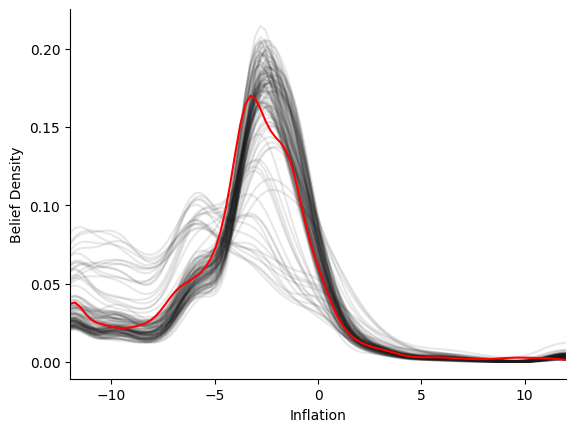

In [47]:
def bins_to_cdf(bins, weights, sup):
    F = np.zeros_like(sup)
    bin_i = 0
    for i in range(1, len(sup)):
        if sup[i] > bins[bin_i+1]:
            bin_i += 1
        n_points_in_bin = ((bins[bin_i] <= sup) & ( sup <= bins[bin_i+1])).sum()
        F[i] = F[i-1] + weights[bin_i] / n_points_in_bin
    return F

def cdf_to_quantiles(q_sup, f_sup, F): return np.interp(q_sup, F, f_sup)

def bins_to_q(bins, weights, q_sup):
    sup_size = q_sup.shape[0]
    f_sup = np.linspace(np.min(bins), np.max(bins), sup_size)
    F = bins_to_cdf(bins, weights, f_sup)
    return cdf_to_quantiles(q_sup, f_sup, F)

def step_function(x, X, Y):
    idx = np.searchsorted(X, x, side='left')
    idx = np.clip(idx, 0, len(Y)-1)
    return Y[idx]

def gaussian_kernel(size, sigma):
    x = np.linspace(-size//2, size//2, size)
    kernel = np.exp(-0.5 * (x / sigma)**2)
    return kernel / kernel.sum()

def smoothen(y, sigma):
    s = int(6 * sigma)+1
    if s % 2 == 0: s += 1
    return np.convolve(
        np.pad(y, (s//2, s//2), mode='edge'),
        gaussian_kernel(s, sigma),
        mode='valid')

def hist_to_smooth_dens(hist, f_sup):
    dens = smoothen(step_function(f_sup, bins[1:], hist), 1.5)
    h = f_sup[1] - f_sup[0]
    return dens / (dens.sum()*h)

def hist_to_smooth_cdf(hist, f_sup):
    dens = hist_to_smooth_dens(hist, f_sup)
    h = f_sup[1] - f_sup[0]
    return dens.cumsum()*h

def hist_to_smooth_q(hist, q_sup, f_sup):
    dens = hist_to_smooth_dens(hist, f_sup)
    h = f_sup[1] - f_sup[0]
    cdf = dens.cumsum()*h
    return cdf_to_quantiles(q_sup, f_sup, cdf)


bins = np.array([ -12, -8, -4, -2, 0, 2, 4, 8, 12 ])
bins_centers = (bins[1:] + bins[:-1])/2

f_sup = np.linspace(-12, 12, 100)
q_sup = np.linspace(0, 1, 100)

def _row_to_hist(row):
    weights = row.values[1:][::-1]/100
    return weights / weights.sum()

def _row_to_smooth_dens(row):
    weights = row.values[1:][::-1]/100
    return hist_to_smooth_dens(weights / weights.sum(), f_sup)

def _row_to_smooth_cdf(row):
    weights = row.values[1:][::-1]/100
    return hist_to_smooth_cdf(weights / weights.sum(), f_sup)

def _row_to_cdf(row):
    weights = row.values[1:][::-1]/100
    weights /= weights.sum()
    return bins_to_cdf(bins, weights, f_sup)

def _row_to_q(row):
    weights = row.values[1:][::-1]/100
    weights /= weights.sum()
    return bins_to_q(bins, weights, q_sup)

def _row_to_smooth_q(row):
    weights = row.values[1:][::-1]/100
    return hist_to_smooth_q(weights / weights.sum(), q_sup, f_sup)
    
hists = np.c_[list(sdf.groupby('date').mean().reset_index().apply(_row_to_hist, axis=1))] 
densities = np.c_[list(sdf.groupby('date').mean().reset_index().apply(_row_to_hist, axis=1))] 
cdfs = np.c_[list(sdf.groupby('date').mean().reset_index().apply(_row_to_cdf, axis=1))]
quantiles = np.c_[list(sdf.groupby('date').mean().reset_index().apply(_row_to_q, axis=1))]
smooth_densities = np.c_[list(sdf.groupby('date').mean().reset_index().apply(_row_to_smooth_dens, axis=1))]
smooth_cdfs = np.c_[list(sdf.groupby('date').mean().reset_index().apply(_row_to_smooth_cdf, axis=1))]
smooth_quantiles = np.c_[list(sdf.groupby('date').mean().reset_index().apply(_row_to_smooth_q, axis=1))]


q_sup = np.linspace(0, 1, 100)
f_sup = np.linspace(-12, 12, 100)

med_qs = np.stack(sdf_all.groupby('date')['Q50'].apply(lambda s: np.quantile(s, q_sup)).values)
med_ds = np.stack(sdf_all.groupby('date')['Q50'].apply(lambda s: stats.gaussian_kde(s)(f_sup)))
med_cdf = np.stack(sdf_all.groupby('date')['Q50'].apply(lambda s: stats.ecdf(s).cdf.evaluate(f_sup)))

for i in range(hists.shape[0]):
    plt.plot(f_sup, med_ds[i,:], c=(0.1,0.1,0.1,0.1))

W = W1d.Wasserstein1D()
mu_hat = MetricData(W, med_qs).frechet_mean()
plt.plot(
    f_sup,
    stats.gaussian_kde(np.interp(np.random.rand(10000), q_sup, mu_hat))(f_sup),
    color='red'
)

plt.xlabel("Inflation")
plt.ylabel("Belief Density")
plt.xlim(-12,12)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/belief_densities.pdf', bbox_inches='tight', transparent=True,)

In [48]:
def geodesic(x, theta, mu):
    return theta * x + (1-theta)*mu

def phi_hat(x, tol=None):
    mu_hat = MetricData(W, x).frechet_mean()
    T = x.shape[0]
    tol = tol or 1.0 / T
    def L(phi): return np.array([ W._d(x[j+1,:], geodesic(x[j,:], phi, mu_hat))**2 for j in range(T-1) ]).mean()
    return minimize(L, np.random.rand(), method='Nelder-Mead', bounds=[(0,1)], options=dict(xatol=tol))['x'][0]

def bootstrap(x, stat, B):
    bootstrap = np.zeros(B)
    for b in tqdm(range(B)): bootstrap[b] = stat(np.random.permutation(x))
    return bootstrap

def Dt(x):
    return np.array([ W._d(x[j,:], x[j+1,:])**2 for j in range(x.shape[0]-1) ]).mean()

def predict(mu, phi, x):
    x_hat = np.zeros_like(x)
    x_hat[0,:] = mu
    for t in range(1, x.shape[0]):
        x_hat[t, :] = geodesic(x[t-1, :], phi, mu)
    return x_hat

B = 1000
# x = quantiles

# x = smooth_quantiles
# cdfs = smooth_cdfs

x = med_qs
cdfs = med_cdf

W = W1d.Wasserstein1D()
mu_hat = MetricData(W, x).frechet_mean()

phi_hat_ = phi_hat(x)
Dt_ = Dt(x)

x_hat = predict(mu_hat, phi_hat_, x)

err_0 = np.array([ W._d(x[t,:], mu_hat)**2 for t in range(1, x.shape[0]) ])
err = np.array([ W._d(x[t,:], x_hat[t,:])**2 for t in range(1, x.shape[0]) ])

booted_dt = bootstrap(x, Dt, B)

print(f'Dt = {Dt_} (pval={(1 + (Dt_ > booted_dt).sum()) / (1 + booted_dt.shape[0])})')
print(f'phi = {phi_hat_}')
print(f'R^2 = {1 - err.mean() / err_0.mean():.2f}')

100%|██████████| 1000/1000 [00:00<00:00, 1324.25it/s]

Dt = 0.26109490910677013 (pval=0.000999000999000999)
phi = 0.9161155416075425
R^2 = 0.82


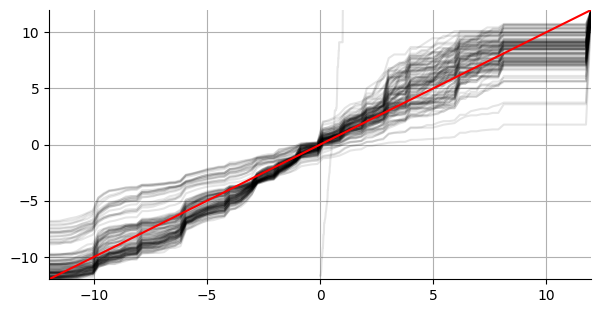

In [47]:
fig = plt.figure(figsize=(7,3.5))
plt.plot(q_sup, np.interp(cdfs[1,:], q_sup, x_hat[1,:]), color='black', alpha=0.1, label='Residual Maps')
for i in range(1,x.shape[0]):
    res = np.interp(cdfs[i,:], q_sup, mu_hat)
    plt.plot(f_sup, res, color='black', alpha=0.1)
plt.plot(f_sup, f_sup, color='red', label='Identity Map')
plt.xlim(-12,12)
plt.ylim(-12,12)
ax = plt.gca()
ax.grid('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/residuals_null.pdf', bbox_inches='tight', transparent=True,)

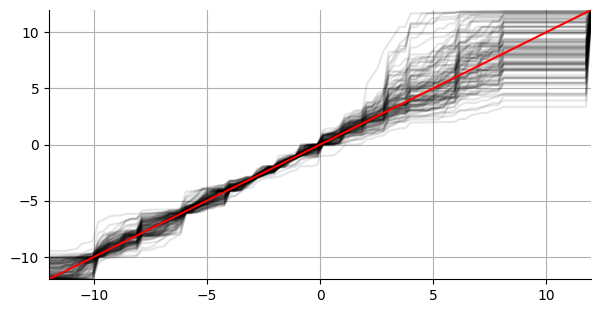

In [48]:
fig = plt.figure(figsize=(7,3.5))
plt.plot(f_sup, np.interp(cdfs[1,:], q_sup, x_hat[1,:]), color='black', alpha=0.1, label='Residual Maps')

for i in range(1,x.shape[0]):
    res = np.interp(cdfs[i,:], q_sup, x_hat[i,:])
    plt.plot(f_sup, res, color='black', alpha=0.1)
plt.plot(f_sup, f_sup, color='red', label='Identity Map')
plt.xlim(-12,12)
plt.ylim(-12,12)
ax = plt.gca()
ax.grid('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/residuals_model.pdf', bbox_inches='tight', transparent=True,)

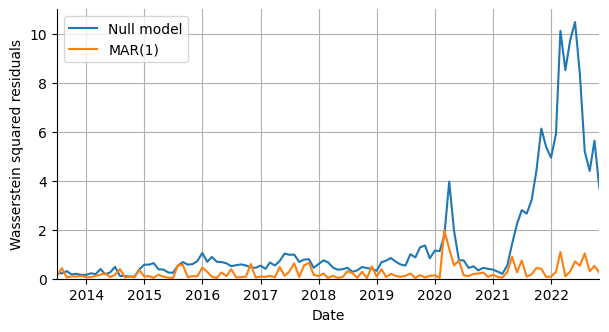

In [7]:
fig = plt.figure(figsize=(7,3.5))

dates = pd.to_datetime(sdf_all.groupby('date').count().index, format='%Y%m')[1:]

plt.plot(dates, err_0, label='Null model')
plt.plot(dates, err, label='MAR(1)')

# plt.plot(np.arange(err_0.shape[0]), err_0, label='Null model')
# plt.plot(np.arange(err.shape[0]), err, label='MAR(1)')

# plt.scatter(np.arange(err_0.shape[0]), err_0, label='Null model')
# plt.scatter(np.arange(err.shape[0]), err, label='MAR(1)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Wasserstein squared residuals')
plt.ylim(0)
plt.xlim(dates[0], dates[-1])
# plt.xlim(0,x.shape[0])
# plt.xticks(pd.to_datetime(sdf_all.groupby('date').count().index, format='%Y%m'))

ax = plt.gca()
ax.grid('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/data_residuals_time.pdf', bbox_inches='tight', transparent=True,)

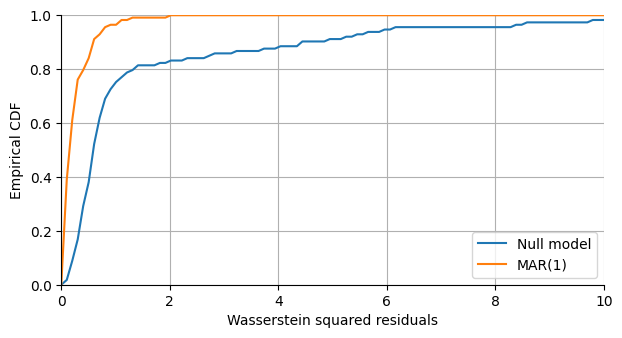

In [9]:
fig = plt.figure(figsize=(7,3.5))
dom = np.linspace(0,10,100)

plt.plot(dom, stats.ecdf(err_0).cdf.evaluate(dom), label='Null model')
plt.plot(dom, stats.ecdf(err).cdf.evaluate(dom), label='MAR(1)')

plt.legend()
plt.xlabel('Wasserstein squared residuals')
plt.ylabel('Empirical CDF')
plt.ylim(0,1)
plt.xlim(0,10)
ax = plt.gca()
ax.grid('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./plots/data_residuals_ecdf.pdf', bbox_inches='tight', transparent=True,)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

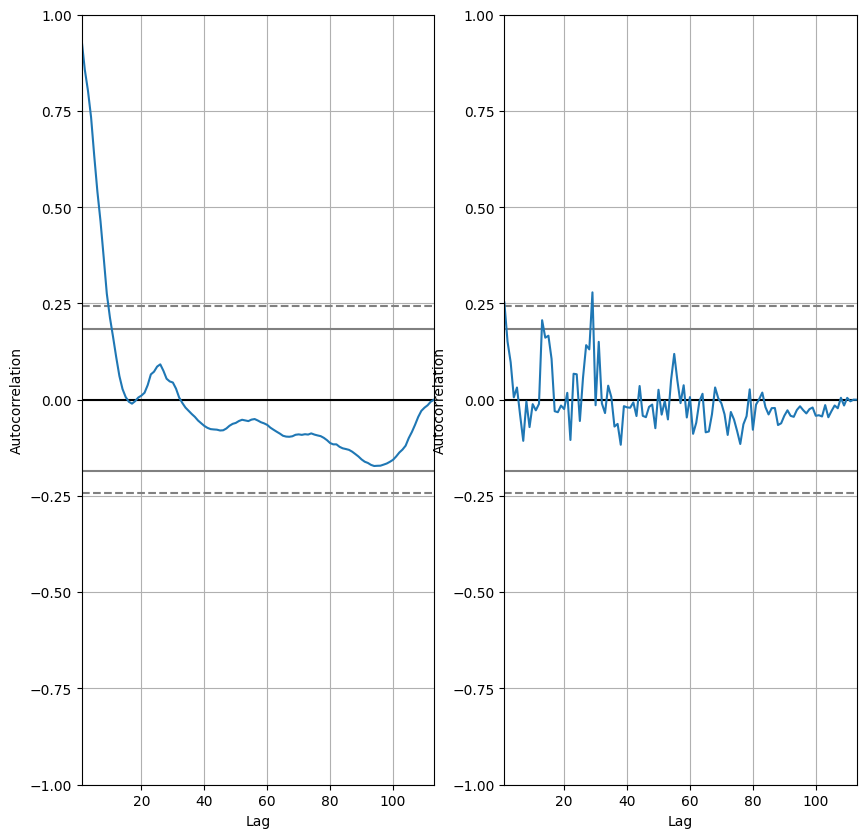

In [212]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
pd.plotting.autocorrelation_plot(err_0)  
plt.subplot(1,2,2)
pd.plotting.autocorrelation_plot(err)  